In [1]:
import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.
from flax import nnx  # The Flax NNX API.
from functools import partial
import jax.numpy as jnp  # JAX NumPy
import jax
import optax
from linearRNN import forward_h
from linearRNN import forward
from linearRNN import init_lru_parameters
from linearRNN import binary_operator_diag
from linearRNN import LRU
import numpy as np
from flax import linen as nn


In [38]:
rnn=1 #rnn=0:transformation of the inputs with fixed RNN weights, rnn=1: adding the RNN module on the model to learn the weight matrices
mlp=1
hidden_neuron=128
encoded_size=512
hidden_size=384
learning_rate = 0.004
momentum = 0.9
train_steps=1200
eval_every = 100
batch_size=50
r_min = 0
r_max = 1
max_phase = 6.28
depth=1
method_name="LRUMLP1"
dataset_name="MNIST"
leave_data=1

In [3]:
#Import data

if dataset_name=="MNIST":
    dataset=tf.keras.datasets.mnist.load_data()
    train=dataset[0]
    test=dataset[1]

    train_x_seq=train[0].shape[0]
    train_x_len=int(jnp.prod(jnp.array(train[0].shape[1:])))
    train_x_size=1
    test_x_seq=test[0].shape[0]
    test_x_len=int(jnp.prod(jnp.array(test[0].shape[1:])))
    test_x_size=1

    train_x=train[0].reshape((train_x_seq,train_x_len,train_x_size))/255
    train_y=train[1].reshape(train_x_seq)
    train_y_class=len(jnp.unique(train_y))

    test_x=test[0].reshape((test_x_seq,test_x_len,test_x_size))/255
    test_y=test[1].reshape(test_x_seq)

if dataset_name=="CIFAR10":
    dataset=tf.keras.datasets.cifar10.load_data()
    train=dataset[0]
    test=dataset[1]

    train_x_seq=train[0].shape[0]
    train_x_len=int(jnp.prod(jnp.array(train[0].shape[1:-1])))
    train_x_size=int(jnp.prod(jnp.array(train[0].shape[-1])))

    test_x_seq=test[0].shape[0]
    test_x_len=int(jnp.prod(jnp.array(test[0].shape[1:-1])))
    test_x_size=int(jnp.prod(jnp.array(train[0].shape[-1])))

    train_x=train[0].reshape((train_x_seq,train_x_len,train_x_size))/255

    train_y=train[1].reshape(train_x_seq)
    train_y_class=len(jnp.unique(train_y))

    test_x=test[0].reshape((test_x_seq,test_x_len,test_x_size))/255
    test_y=test[1].reshape(test_x_seq)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(60000, 784, 1)
(60000,)
(10000, 784, 1)
(10000,)


In [4]:
if rnn:
    train_hidden_state=train_x
    test_hidden_state=test_x
else:
    param=init_lru_parameters(hidden_size,train_x_len,r_min=0.999,r_max=0.9999,max_phase=6.28)
    param2=init_lru_parameters(hidden_size,train_x_size,r_min=0.999,r_max=0.9999,max_phase=6.28)
    train_hidden_state=jnp.real(forward_h(param,train_x))
    test_hidden_state=jnp.real(forward_h(param2,test_x))

In [5]:
train_ds=tf.data.Dataset.from_tensor_slices((jnp.real(train_hidden_state),jnp.array(train_y,dtype=int)))
test_ds=tf.data.Dataset.from_tensor_slices((jnp.real(test_hidden_state),jnp.array(test_y,dtype=int)))

train_ds = train_ds.repeat().shuffle(100)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

In [6]:
print(train_hidden_state.shape)
print(test_hidden_state.shape)

(60000, 784, 1)
(10000, 784, 1)


In [ ]:
from flax import nnx
import optax
from flax.nnx.nn.recurrent import LSTMCell,GRUCell
import copy
import random
class MLP(nnx.Module):
  #DON'T FORGET TO CHANGE THE MODEL NAME BEFORE RUNNING
  #According to the scheme of the paper (Figure 1), input_size=M, encoded_size=H,layer_dim=number of neurons in MLP, out_dim=number of classes
  def __init__(self, token_size, token_len,encoded_dim,hidden_dim, layer_dim, out_dim, rngs: nnx.Rngs):

    #linear encoder
    self.lin_encoder = nnx.Linear(in_features=token_size, out_features=encoded_dim,rngs=rngs)
    #self.lin_encoder=nnx.Param(jnp.array(np.random.rand(token_size,encoded_dim)))
    #LRU+MLP block
    self.rnn = LRU(in_features=encoded_dim, hidden_features=hidden_dim, r_min=r_min,r_max=r_max,max_phase=max_phase)
    self.linear1 = nnx.Linear(in_features=encoded_dim, out_features=layer_dim, rngs=rngs)
    self.linear2 = nnx.Linear(in_features=layer_dim,out_features=encoded_dim,rngs=rngs)

    #Linear layers
    self.linear3= nnx.Linear(in_features=token_len,out_features=1,rngs=rngs)
    self.linear4= nnx.Linear(in_features=encoded_dim,out_features=out_dim,rngs=rngs)
    #self.weight = nnx.Param(jnp.array(np.random.rand(token_len,1)))
    #self.bias = nnx.Param(jnp.array(np.random.rand(encoded_dim,1)))
    #self.weight2 = nnx.Param(jnp.array(np.random.rand(out_dim,encoded_dim)))
    #self.bias2 = nnx.Param(jnp.array(np.random.rand(out_dim,1)))
    self.out_dim = out_dim

    
  @nnx.vmap(in_axes=(None,0)) 
  def __call__(self, x):
    x = self.lin_encoder(x)
    #x=x@self.lin_encoder
    y = x.copy()
    #LRU+MLP block
    for i in range(depth):
      x = self.rnn(x)
      x = self.linear1(x)
      x = nnx.relu(x)
      x = self.linear2(x)

    x += y #Skip connection
    #x = x.T@self.weight #+ self.bias #project from L*H to H*1
    #x = self.weight2@x #+ self.bias2#project from H*1 to out_dim
    x=self.linear3(x.T)
    x=self.linear4(x.T)
    return x.reshape(self.out_dim)


model = MLP(train_x_size,train_x_len,encoded_size,hidden_size, hidden_neuron, train_y_class, rngs=nnx.Rngs(0))  # eager initialization

nnx.display(model)

MLP(
  lin_encoder=Param(
    value=Array(shape=(1, 512), dtype=float32)
  ),
  rnn=LRU(
    in_features=512,
    hidden_features=384,
    nu_log=Param(
      value=Array(shape=(384,), dtype=float64)
    ),
    theta_log=Param(
      value=Array(shape=(384,), dtype=float64)
    ),
    B_re=Param(
      value=Array(shape=(384, 512), dtype=float64)
    ),
    B_im=Param(
      value=Array(shape=(384, 512), dtype=float64)
    ),
    C_re=Param(
      value=Array(shape=(512, 384), dtype=float64)
    ),
    C_im=Param(
      value=Array(shape=(512, 384), dtype=float64)
    ),
    D=Param(
      value=Array(shape=(512,), dtype=float64)
    ),
    gamma_log=Param(
      value=Array(shape=(384,), dtype=float64)
    )
  ),
  linear1=Linear(
    kernel=Param(
      value=Array(shape=(512, 128), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(128,), dtype=float32)
    ),
    in_features=512,
    out_features=128,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.

In [ ]:
#Test the model with the first batch
#for step, batch in enumerate(train_ds.as_numpy_iterator()):
#    batch1=batch
#    break
#a=model(batch[0])
#print(a)

In [34]:
import optax

#scheduler = optax.piecewise_constant_schedule(init_value=learning_rate, boundaries_and_scales={int(train_steps*0.1):0.1})
#optimizer = nnx.Optimizer(model, optax.adamw(scheduler, momentum,weight_decay=0.05))
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum,weight_decay=0.05))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)

Optimizer(
  step=OptState(
    value=Array(0, dtype=uint32)
  ),
  model=MLP(
    lin_encoder=Param(
      value=Array(shape=(1, 512), dtype=float32)
    ),
    linear1=Linear(
      bias=Param(
        value=Array(shape=(128,), dtype=float32)
      ),
      bias_init=<function zeros at 0x000002C914B3A160>,
      dot_general=<function dot_general at 0x000002C9146A0D60>,
      dtype=None,
      in_features=512,
      kernel=Param(
        value=Array(shape=(512, 128), dtype=float32)
      ),
      kernel_init=<function variance_scaling.<locals>.init at 0x000002C917EAEC00>,
      out_features=128,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      use_bias=True
    ),
    linear2=Linear(
      bias=Param(
        value=Array(shape=(512,), dtype=float32)
      ),
      bias_init=<function zeros at 0x000002C914B3A160>,
      dot_general=<function dot_general at 0x000002C9146A0D60>,
      dtype=None,
      in_features=128,
      kernel=Param(
        value=Array(sha

In [35]:
import jax
def loss_fn(model: MLP, batch):
  logits = model(batch[0])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch[1]
  ).mean()
  #print(logits.shape)
  #print(batch[1].shape)
  return loss, logits

@nnx.jit
def train_step(model: MLP, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch[1])  # In-place updates.
  optimizer.update(grads)  # In-place updates.
  predicted_labels = jnp.argmax(logits, axis=-1)
  actual_labels = batch[1]
  #jax.debug.print("Predictions: {}",predicted_labels[:5].astype(int))
  #jax.debug.print("Actual Labels: {}",actual_labels[:5].astype(int))
  
@nnx.jit
def eval_step(model: MLP, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch[1])  # In-place updates.

In [36]:
#Train the model + evaluation with the test data
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)

  if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the next training epoch.

    print(
      f"[train] step: {step}, "
      f"loss: {metrics_history['train_loss'][-1]}, "
      f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
    )
    print(
      f"[test] step: {step}, "
      f"loss: {metrics_history['test_loss'][-1]}, "
      f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
    )

[train] step: 100, loss: 1.043755292892456, accuracy: 68.39603424072266
[test] step: 100, loss: 0.6328961849212646, accuracy: 81.0999984741211
[train] step: 200, loss: 0.5660642981529236, accuracy: 83.27999877929688
[test] step: 200, loss: 0.44337818026542664, accuracy: 86.83999633789062
[train] step: 300, loss: 0.4466700255870819, accuracy: 86.5199966430664
[test] step: 300, loss: 0.4424591362476349, accuracy: 86.12999725341797
[train] step: 400, loss: 0.3896907866001129, accuracy: 88.31999969482422
[test] step: 400, loss: 0.4339284598827362, accuracy: 86.40999603271484
[train] step: 500, loss: 0.38452017307281494, accuracy: 88.55999755859375
[test] step: 500, loss: 0.33932018280029297, accuracy: 89.76000213623047
[train] step: 600, loss: 0.3293919265270233, accuracy: 89.84000396728516
[test] step: 600, loss: 0.2831813097000122, accuracy: 91.44999694824219
[train] step: 700, loss: 0.30610957741737366, accuracy: 91.04000091552734
[test] step: 700, loss: 0.35560527443885803, accuracy: 8

In [39]:
#Save the training results into csv
import pandas as pd

if leave_data:
    data=pd.DataFrame({"step":np.arange(eval_every,train_steps+eval_every,eval_every),"train_loss":metrics_history['train_loss'],
                       "test_loss":metrics_history['test_loss'],"train_accuracy":metrics_history['train_accuracy'],
                       "test_accuracy":metrics_history['test_accuracy']})
    if mlp:
        data.to_csv(method_name+"_enc"+str(encoded_size)+"_nr"+str(hidden_neuron)+"_d"+str(hidden_size)+"_"+dataset_name+"_step"+str(train_steps)+"r_min_"+str(r_min)+"r_max"+str(r_max)+".csv")
    #else:
    #    data.to_csv(method_name+"_d"+str(hidden_size)+"_"+dataset_name+"_step"+str(train_steps)+".csv")

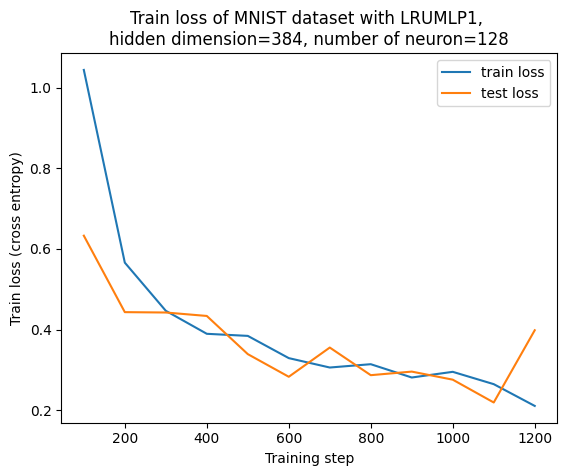

In [40]:
#Plot the loss
import matplotlib.pyplot as plt

plt.plot(np.arange(eval_every,train_steps+eval_every,eval_every),metrics_history['train_loss'],label="train loss")
plt.plot(np.arange(eval_every,train_steps+eval_every,eval_every),metrics_history['test_loss'],label="test loss")
if mlp:
    plt.title("Train loss of "+dataset_name+" dataset with "+method_name+
              ", \nhidden dimension="+str(hidden_size)+", number of neuron="+str(hidden_neuron))
#else:
#    plt.title("Train loss of MNIST dataset with GRU+MLP, \nhidden dimension="+str(hidden_size))
plt.xlabel("Training step")
plt.ylabel("Train loss (cross entropy)")
plt.legend()
if leave_data:
    plt.savefig("loss_"+method_name+"_"+str(encoded_size)+"_"+str(hidden_neuron)+"_"+dataset_name+"_step"+str(train_steps)+"r_min_"+str(r_min)+"r_max"+str(r_max)+".jpg")
plt.show()

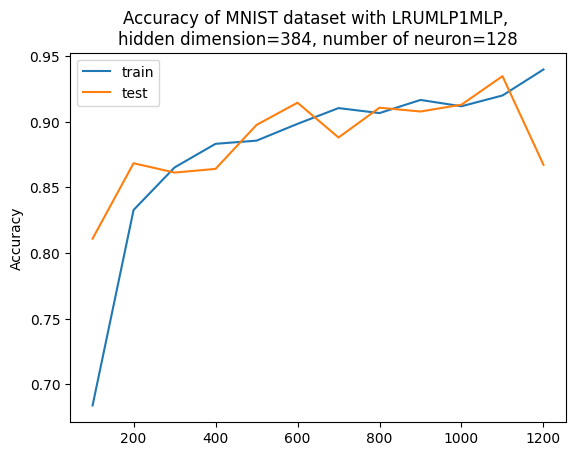

In [41]:
#Plot the accuracy
plt.plot(np.arange(eval_every,train_steps+eval_every,eval_every),metrics_history['train_accuracy'],label="train")
plt.plot(np.arange(eval_every,train_steps+eval_every,eval_every),metrics_history['test_accuracy'],label="test")
plt.title("Accuracy of "+dataset_name+" dataset with "+method_name+"MLP, \nhidden dimension="+
          str(hidden_size)+", number of neuron="+str(hidden_neuron))
plt.ylabel("Accuracy")
plt.legend()
if leave_data:
    plt.savefig("accuracy_"+method_name+"_"+str(encoded_size)+"_"+str(hidden_neuron)+"_"+dataset_name+"_step"+str(train_steps)+"r_min_"+str(r_min)+"r_max"+str(r_max)+".jpg")
plt.show()